In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as mgrid
import numpy as np

import warnings

from activ.readfile import TrackTBIFile
from activ.nmf.viz import bases_heatmap, bases_factor_order, get_percent_top, plot_bases, plot_weights,\
                          nmfplot, plot_umap_nmf_piechart, plot_umap_nmf_max, plot_umap_nmf_weight, cumulative_plot

import scipy.spatial.distance as spd

import seaborn as sns

import itertools as it
import pandas as pd
import scipy.cluster.hierarchy as sch
from sklearn.preprocessing import normalize

from mpl_toolkits.axes_grid1 import make_axes_locatable
import latex
from umap import UMAP

In [2]:
tbifile = TrackTBIFile('tracktbi.reg_nmf.h5')
bm_weights, bm_bases = tbifile.nmf.bm, tbifile.nmf.bm_bases
oc_weights, oc_bases = tbifile.nmf.oc, tbifile.nmf.oc_bases

In [3]:
bm_labels = get_percent_top(tbifile.biomarker_features, bm_bases, perc=0.9)
oc_labels = get_percent_top(tbifile.outcome_features, oc_bases, perc=0.9)

In [4]:
bm_colors = sns.color_palette('Set2', 8)
bm_colors = [bm_colors[i] for i in (5,1,2,3,4)]

oc_colors = sns.color_palette('Set2', 8)
oc_colors = [oc_colors[i] for i in (0, 1, 6, 7, 4, 5, 2, 3)]

bm_emb = UMAP(n_components=2, min_dist=1.0, random_state=20001).fit_transform(tbifile.biomarkers)
oc_emb = UMAP(n_components=2, min_dist=0.0, random_state=20001).fit_transform(tbifile.outcomes)

In [5]:
from io import StringIO

def write_groups_pdf(labels, label_names, path):
    ltx = StringIO()
    pr = lambda x: print(x, file=ltx)


    pr("\documentclass{article}")
    pr("\\usepackage{geometry}")
    pr("\\geometry{a4paper, portrait, left=.75in, right=.75in, top=2in, bottom=2in}")

    pr("\\usepackage{multicol}")
    pr("\\begin{document}")

    for i in range(len(labels)):
        pr('\section{%s}' % label_names[i])
        pr("\\begin{multicols}{2}")
        pr("\\begin{enumerate}")
        for lbl in labels[i]:
            pr("\item %s" % lbl)
        pr("\\end{enumerate}")
        pr("\\end{multicols}")
        pr("\\newpage")

    pr("\end{document}")
    s = ltx.getvalue().replace('_', '\\textunderscore ')
    latex.build_pdf(s).save_to(path)

In [6]:
oc_bases_labels = [
    'Insomnia',
    'Dysphoria and\ndepression', # Depression
    'LT cognitive\nimpairment', # long-term cognitive deficits
    'ST cognitive\nimpairment', # short-term cognitive deficits
    'Dizziness and\nheadache',
    'Verbal working\nmemory',    # verbal learning
    'Good outcome',     # Recovered
    'Positive PTSD' # PTSD
]
write_groups_pdf(oc_labels, oc_bases_labels, 'outcome_nmf_classes-2.pdf')

In [7]:
bm_bases_labels = [
    'PE income-related',    # mild/discharged
    'PE age-related',             # pre-existing health conditions and age
    'PE substance-related',    # pre-existing psych
    'Severe TBI',        # severe injury
#    'GCS and general\nseverity measures'                     # general severity measure
    'Mild TBI'
]
#nmfplot(bm_weights, bm_bases, axes=axes, bases_labels=bm_bases_labels)
write_groups_pdf(bm_labels, bm_bases_labels, 'biomarker_nmf_classes.pdf')

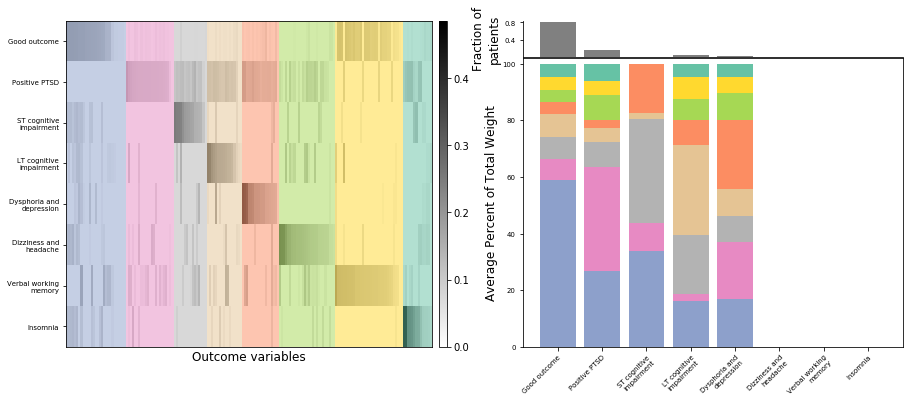

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
ax_hm = axes[0]
ax_bp = axes[1]
ax_bp2 = make_axes_locatable(ax_bp).append_axes("top", 0.5, pad=0.02, sharex=ax_bp)
axes = [ax_hm, ax_bp2, ax_bp]
factor_order = nmfplot(oc_weights, oc_bases, axes=axes, bases_order=False, bases_labels=oc_bases_labels, 
                       fontsize='large', heatmap_xlabel="Outcome variables", labelsize='x-small', palette=oc_colors)

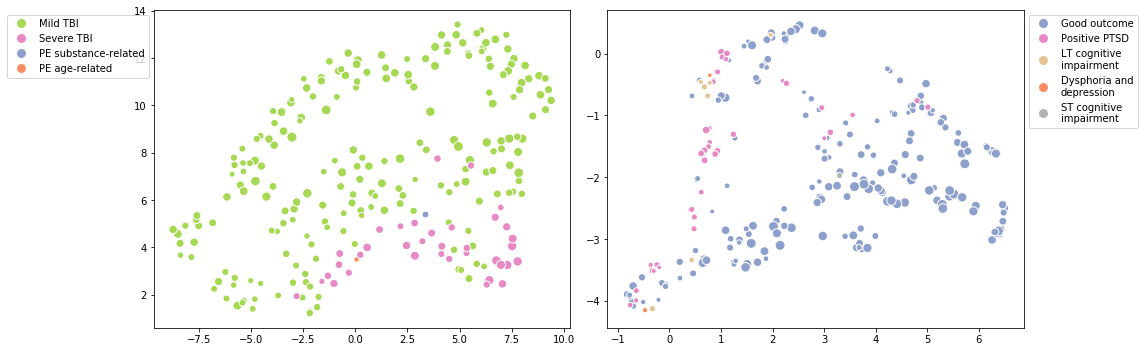

In [9]:
plt.figure(figsize=(16, 5))
plt.subplot(1,2,1)
plot_umap_nmf_max(bm_emb, bm_weights, bm_bases_labels, min_dist=1.0, palette=bm_colors)
plt.subplot(1,2,2)
plot_umap_nmf_max(oc_emb, oc_weights, oc_bases_labels, right=True, palette=oc_colors)
plt.tight_layout()
plt.savefig("nmf_labelled_umap.png", dpi=200)

# multi-panel figure 
- a, b, c - bm barplot, bm heatmap, bm umap-pie-chart
- d, e, f - oc barplot, oc heatmap, oc umap-pie-chart

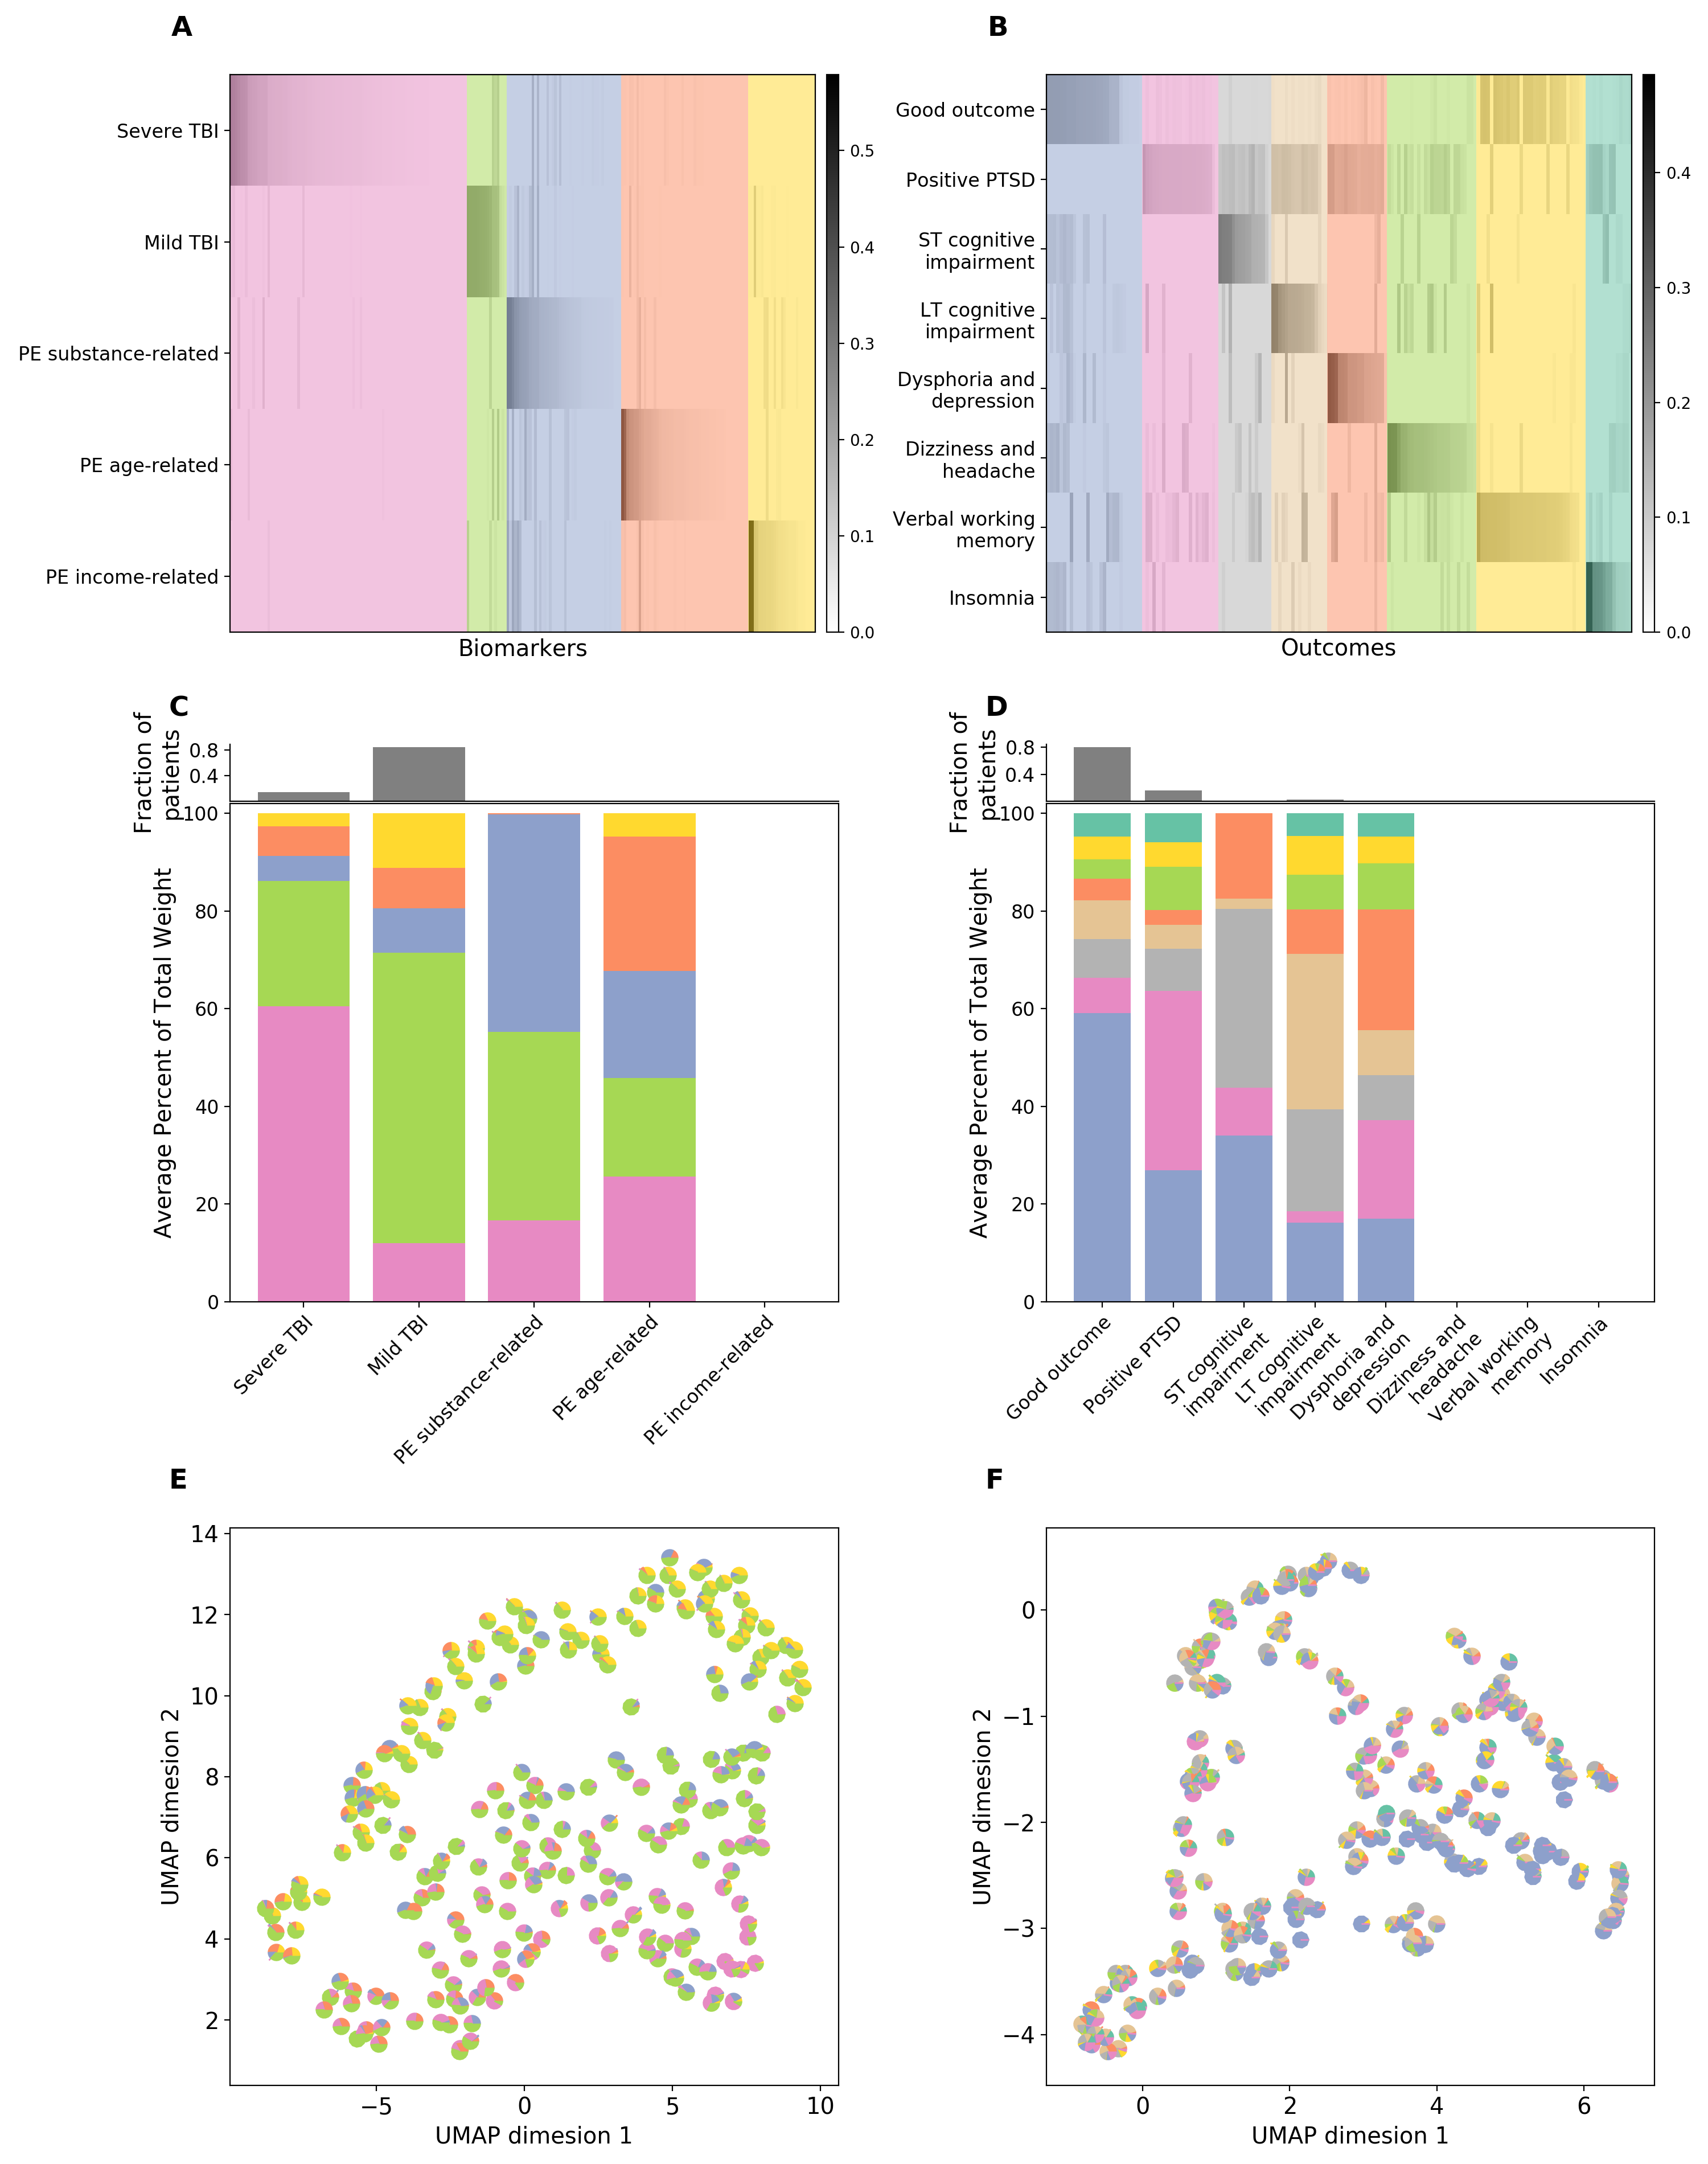

In [10]:
def add_label(ax, label, x=-0.1, y=1.07):
    ax.text(x, y, label,  weight='bold', transform=ax.transAxes, size='xx-large')    
#################################################

fig_width = 15
fig_height = 20

fig, axes = plt.subplots(3, 2, figsize=(15, 20))

axA = axes[0, 0]
axC = axes[1 ,0]
axB = axes[0, 1]
axD = axes[1, 1]
axE = axes[2, 0]
axF = axes[2, 1]

# below height and pad are in inches
axC_bar = make_axes_locatable(axC).append_axes("top", 0.5, pad=0.02, sharex=axC)
axD_bar = make_axes_locatable(axD).append_axes("top", 0.5, pad=0.02, sharex=axD)


fs = 'x-large'
ls = 'large'

nmfplot(bm_weights, bm_bases, axes=[axA, axC_bar, axC], bases_order=False, bases_labels=bm_bases_labels, 
        fontsize=fs, heatmap_xlabel='Biomarkers', palette=bm_colors, labelsize=ls)
plot_umap_nmf_piechart(bm_weights/np.sum(bm_bases != 0, axis=1), bm_emb, s=70, ax=axE, fontsize=fs, palette=bm_colors)


nmfplot(oc_weights, oc_bases, axes=[axB, axD_bar, axD], bases_order=False, bases_labels=oc_bases_labels, 
        fontsize=fs, heatmap_xlabel='Outcomes', palette=oc_colors, labelsize=ls)
plot_umap_nmf_piechart(oc_weights/np.sum(oc_bases != 0, axis=1), oc_emb, s=70, ax=axF, fontsize=fs, palette=oc_colors)


# plot_umap_nmf_max(tbifile.biomarkers, bm_weights, bm_bases_labels, min_dist=1.0, ax=axes[2, 0], legend=False)
# plot_umap_nmf_max(tbifile.outcomes, oc_weights, oc_bases_labels, right=True, ax=axes[2, 1], legend=False)


for ax, lbl in zip([axA, axB, axE, axF] , "ABEF"):
    add_label(ax, lbl)

for ax, lbl in zip([axC_bar, axD_bar], "CD"):
    add_label(ax, lbl, y=1.5)
    
from PIL import Image
    
plt.tight_layout(h_pad=0.02)
fig_path = '../../paper/MultiPanel_latent_features.png'
fig_dpi = 200
plt.savefig(fig_path, dpi=fig_dpi)
plt.close()

px_w = fig_width * fig_dpi
px_h = fig_height * fig_dpi

im = Image.open(fig_path)

AB = im.crop((0, 0, px_w, 0.3*px_h))
CDEF = im.crop((0, 0.35*px_h, px_w, px_h))

new_image = Image.new('RGB',(AB.size[0], AB.size[1]+CDEF.size[1]), (250,250,250))

new_image.paste(AB, (0,0))
new_image.paste(CDEF, (0, AB.size[1]))
new_image.save(fig_path, format='png')
display(new_image)

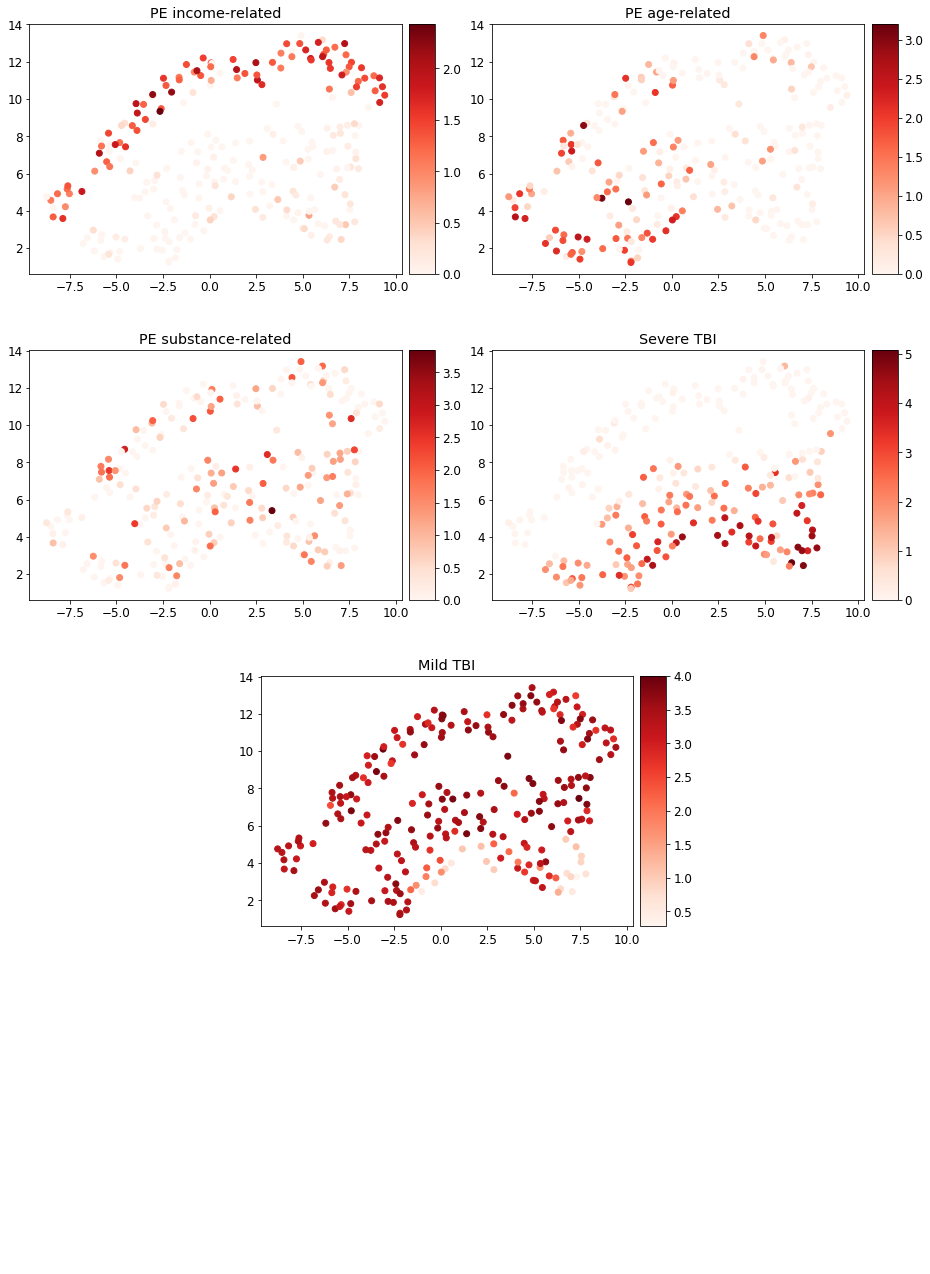

In [11]:
fig = plt.figure(figsize=(13, 18))
gs = mgrid.GridSpec(4, 4, figure=fig)
axes = list()
for i in range(4):
    col = i%2
    axes.append(fig.add_subplot(gs[i//2, col*2:col*2+2]))
axes.append(fig.add_subplot(gs[2, 1:3]))
fig.add_subplot(gs[3, :]).axis('off')
plot_umap_nmf_weight(bm_emb, bm_weights, axes, bm_bases_labels)
plt.tight_layout(h_pad=0.99, w_pad=0.9999)
plt.savefig('../../paper/biomarker_weights_umap.png', dpi=200)

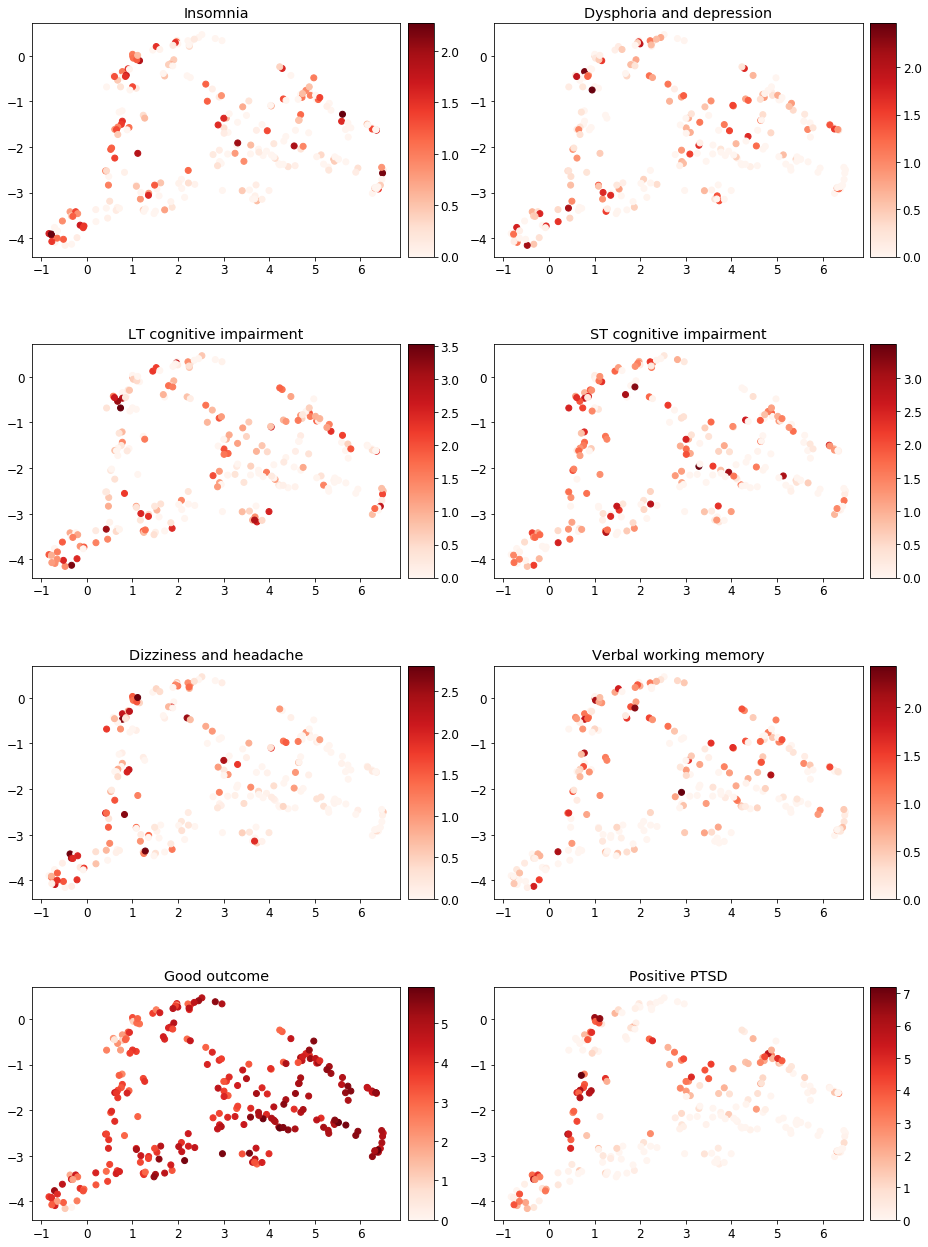

In [12]:
fig = plt.figure(figsize=(13, 18))
gs = mgrid.GridSpec(4, 4, figure=fig)
axes = list()
for i in range(8):
    col = i % 2
    row = i // 2
    axes.append(fig.add_subplot(gs[row, col*2:col*2+2]))

plot_umap_nmf_weight(oc_emb, oc_weights, axes, [s.replace('\n', ' ') for s in oc_bases_labels])
plt.tight_layout(h_pad=0.99, w_pad=0.9999)
plt.savefig('../../paper/outcome_weights_umap.png', dpi=200)

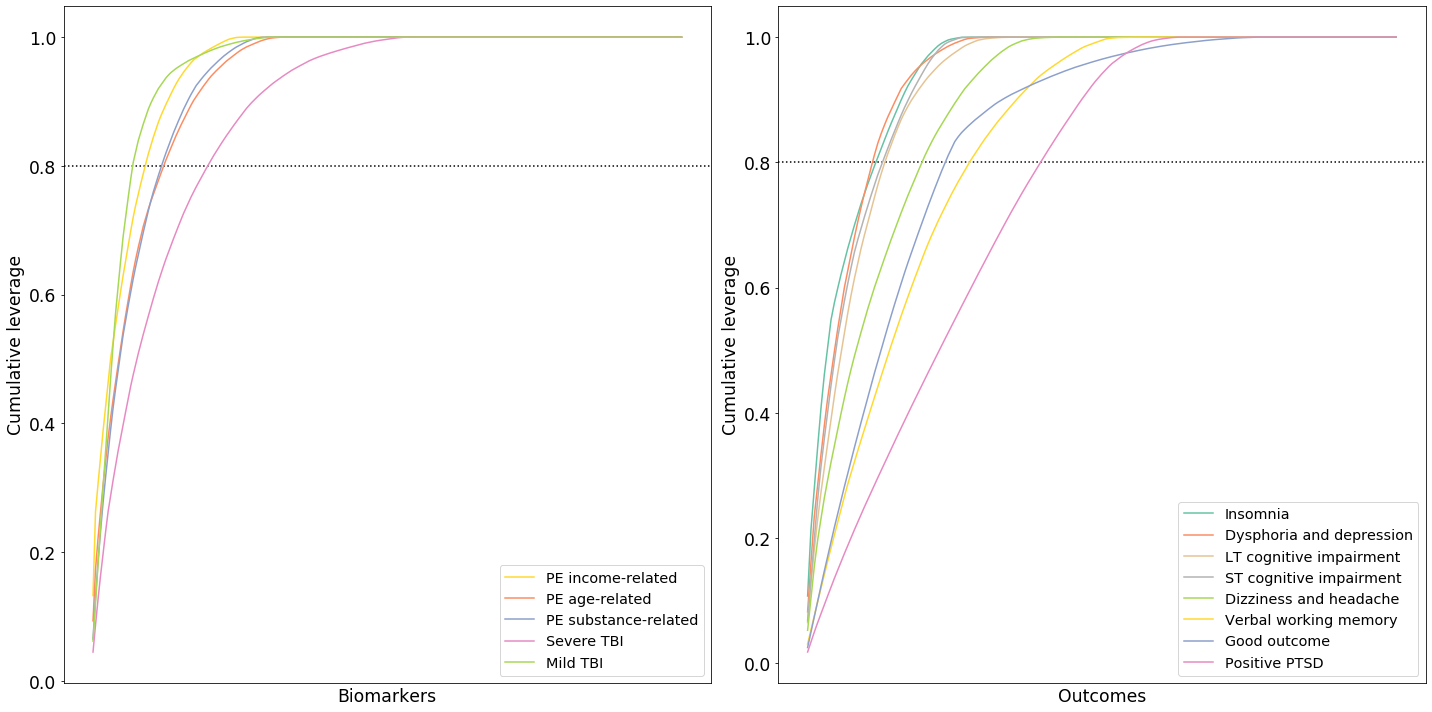

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
cumulative_plot(np.sort(bm_bases, axis=1)[:, ::-1], bm_bases_labels, colors=bm_colors, title='Biomarkers', ax=axes[0])
cumulative_plot(np.sort(oc_bases, axis=1)[:, ::-1], [s.replace('\n', ' ') for s in oc_bases_labels], colors=oc_colors, title='Outcomes', ax=axes[1])
for ax in axes.ravel():
    ax.axhline(0.8, color='k', ls=':', zorder=0)
plt.tight_layout()
plt.savefig('../../paper/bases_cumulative_sorted.png', dpi=200)

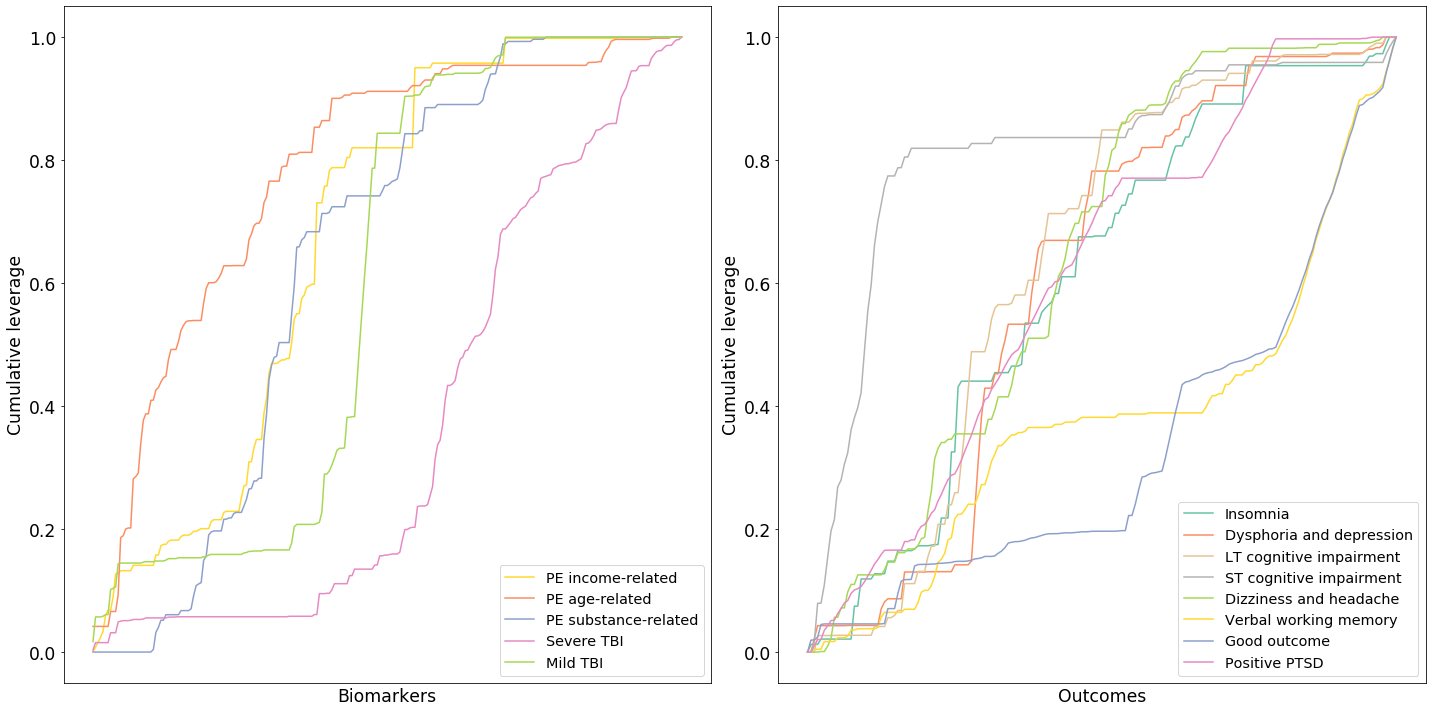

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
cumulative_plot(bm_bases, bm_bases_labels, colors=bm_colors, title='Biomarkers', ax=axes[0])
cumulative_plot(oc_bases, [s.replace('\n', ' ') for s in oc_bases_labels], colors=oc_colors, title='Outcomes', ax=axes[1])
plt.tight_layout()
plt.savefig('../../paper/bases_cumulative.png', dpi=200)

/Users/ajtritt/anaconda/envs/activ_37/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  This is separate from the ipykernel package so we can avoid doing imports until


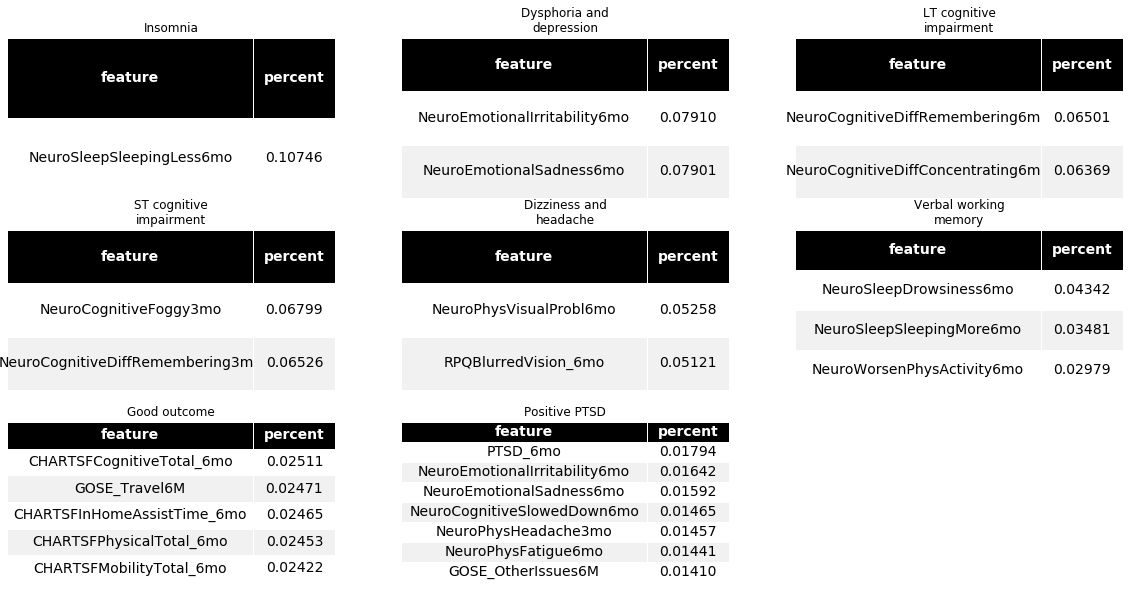

In [21]:
fig, ax = plt.subplots(3, 3, figsize=(20, 10))
plot_tables(tbifile.outcome_features, oc_bases, oc_bases_labels, axes=ax)
plt.tight_layout()
plt.savefig('../../paper/outcomes_top10_features.png', dpi=200)

In [11]:
import pandas as pd

feat, perc = get_percent_top(tbifile.biomarker_features, bm_bases, perc=0.1, return_perc=True)

for f, p, l in zip(feat, perc, bm_bases_labels):
    print(l)
    df = pd.DataFrame(data={'feature':f, 'percent': p})
    print(df)

PE income-related
                         feature   percent
0  PatientTypeCoded_ED.Discharge  0.132438
PE age-related
           feature   percent
0  PMH_Cardiac_ANY  0.093169
1  PMH_Cardiac_HTN  0.079829
PE substance-related
            feature   percent
0     PMH_Psych_ANY  0.064951
1  SHX_IllicitDrugs  0.063641
Severe TBI
                     feature   percent
0  CT_Intracraniallesion_FIN  0.044651
1      AIS_HeadNeckMoreThan2  0.041903
2                 CT_SAH_FIN  0.040003
Mild TBI
             feature   percent
0  injurytype_Closed  0.061760
1        admGCSmotor  0.060276


In [189]:
def render_mpl_table(data, col_width=100.0, row_height=0.625, font_size=14,
                     header_color='k', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)
    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in mpl_table._cells.items():
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax.get_figure(), ax

def plot_tables(features, bases, labels, percent=0.1, axes=None):
    if axes is None:
        nrows = int(np.ceil(np.sqrt(bases.shape[0])))
        ncols = int(np.ceil(bases.shape[0]/nrows))
        print(nrows, ncols)
        fig, axes = plt.subplots(nrows, ncols)

    feat, perc = get_percent_top(features, bases, perc=percent, return_perc=True)
    for f, p, l, ax in zip(feat, perc, labels, axes.ravel()):
        p = ['%0.5f' % _ for _ in p]
        df = pd.DataFrame(data={'feature':f, 'percent': p})
        ax.set_title(l)
        render_mpl_table(df, header_columns=0, col_width=4.0, ax=ax, colWidths=[9, 3], cellLoc='center', fontsize=12)
    for ax in axes.ravel():
        ax.axis('off')
        

/Users/ajtritt/anaconda/envs/activ_37/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  This is separate from the ipykernel package so we can avoid doing imports until


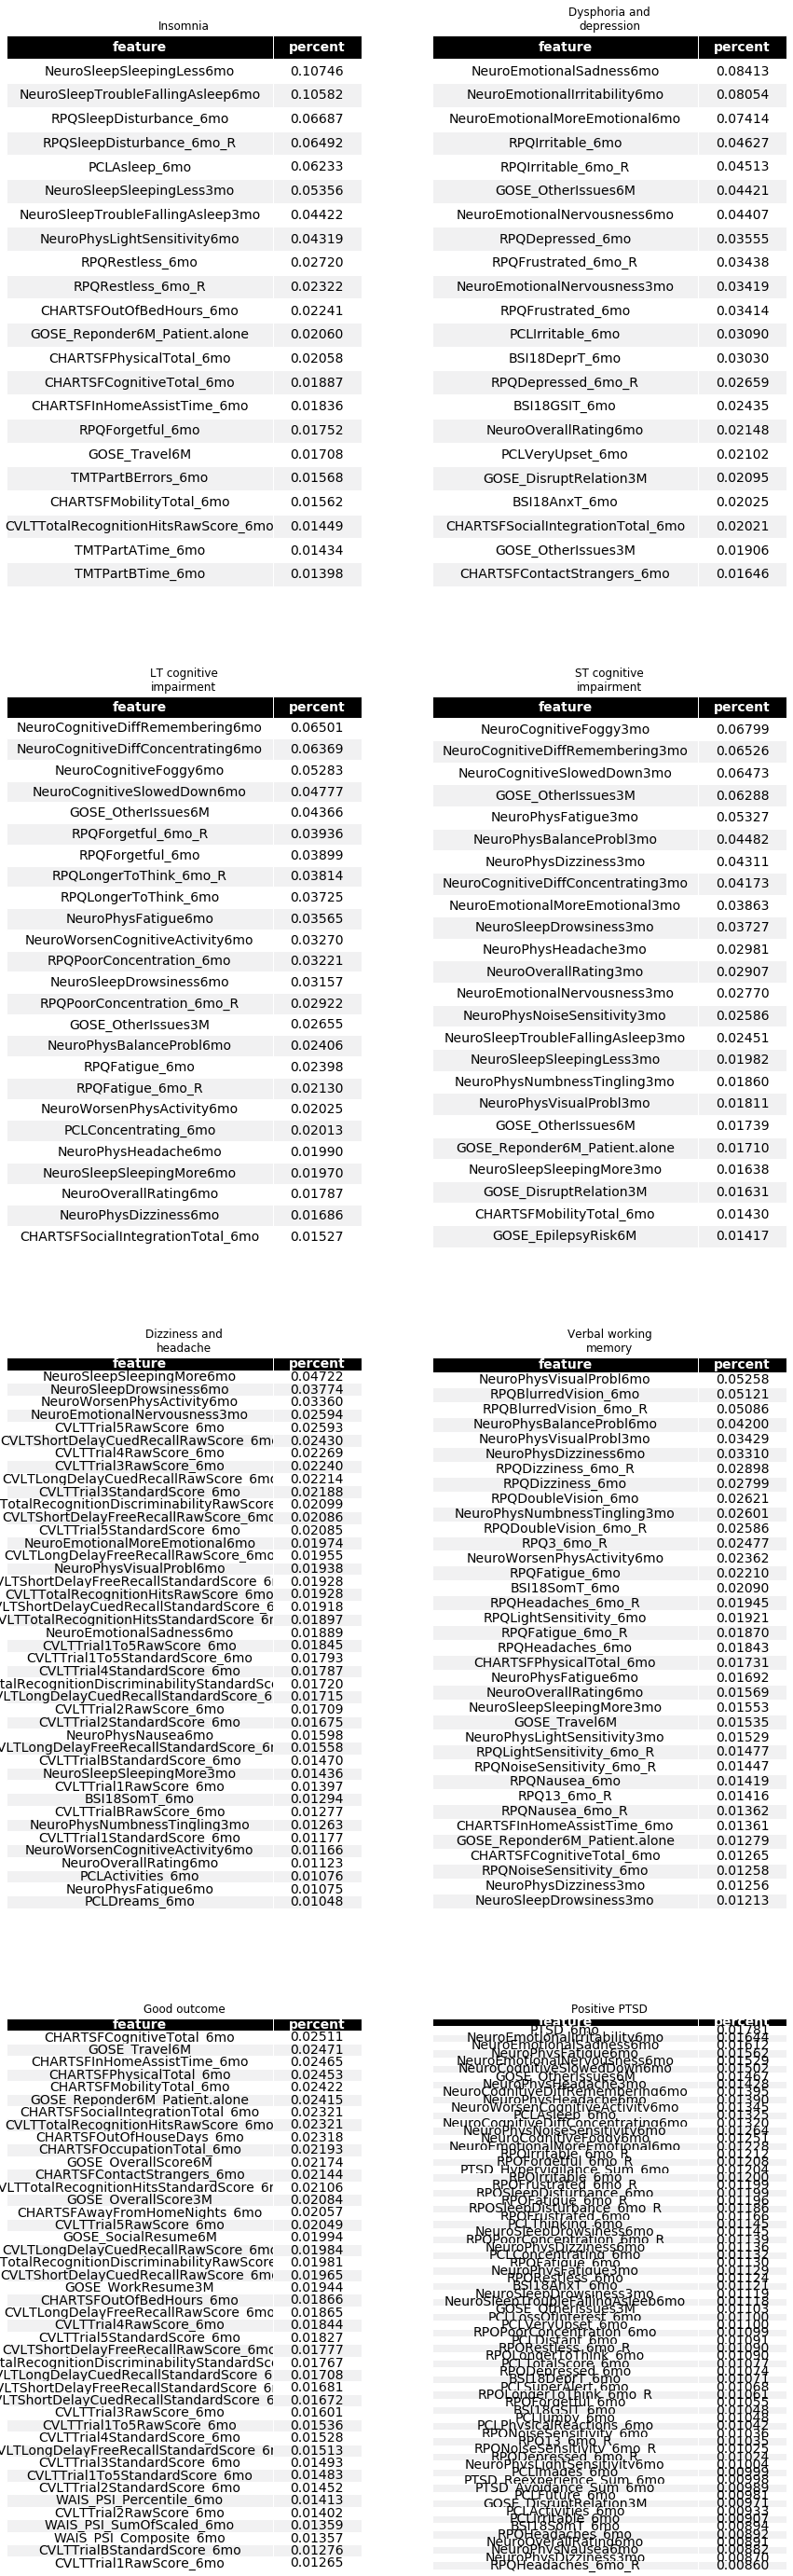

In [196]:
fig, ax = plt.subplots(4, 2, figsize=(15, 50))
plot_tables(tbifile.outcome_features, oc_bases, oc_bases_labels, axes=ax, percent=0.8)
plt.tight_layout()
plt.savefig('../../paper/outcomes_top80_features.png', dpi=200)

/Users/ajtritt/anaconda/envs/activ_37/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  This is separate from the ipykernel package so we can avoid doing imports until


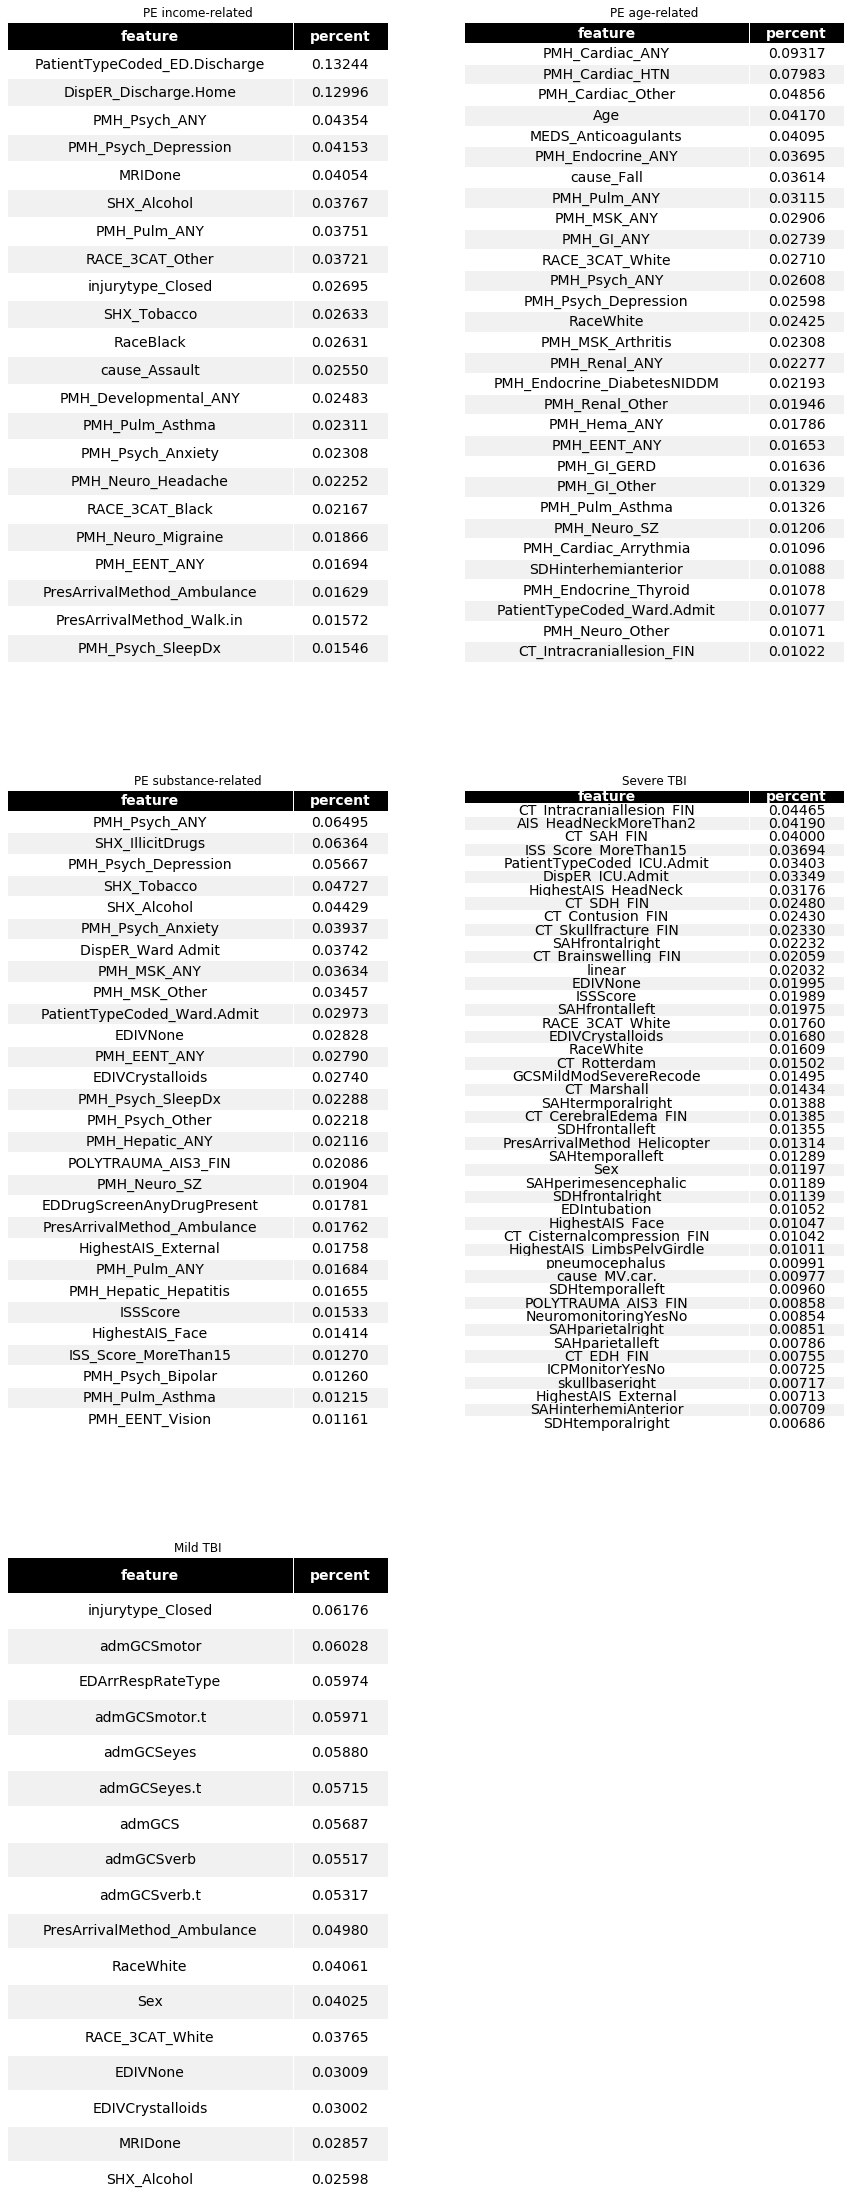

In [191]:
fig, ax = plt.subplots(3, 2, figsize=(15, 40))
plot_tables(tbifile.biomarker_features, bm_bases, bm_bases_labels, axes=ax, percent=0.8)
plt.tight_layout()
plt.savefig('../../paper/biomarkers_top80_features.png', dpi=200)

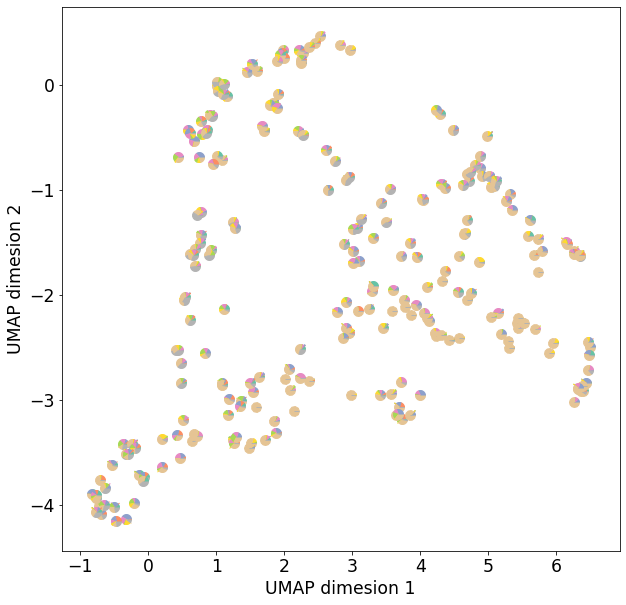

In [22]:
plt.figure(figsize=(10,10))
pie_chart_scatter(oc_weights, oc_emb, s=170, fontsize='xx-large')

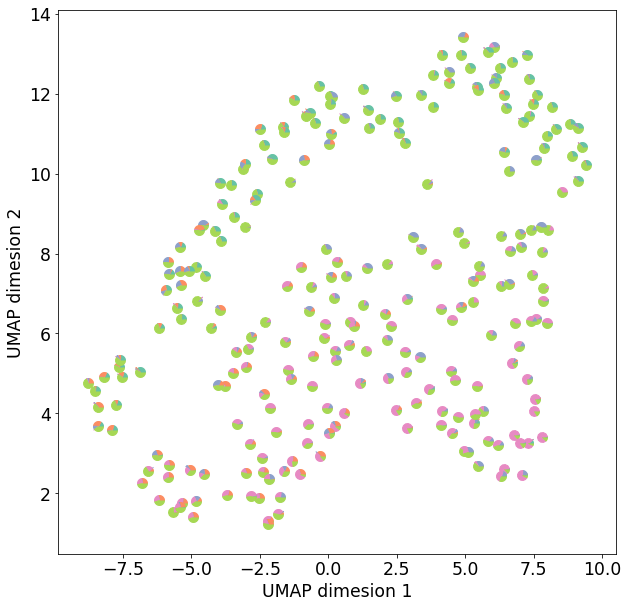

In [23]:
plt.figure(figsize=(10,10))
pie_chart_scatter(bm_weights, bm_emb, s=170, fontsize='xx-large')

In [24]:
[0, 1, 2, 4][:2]

[0, 1]

In [25]:

nmfplot(bm_weights, bm_bases, axes=axes, bases_order=False, bases_labels=bm_bases_labels, fontsize='large', heatmap_xlabel='Biomarkers')
plt.tight_layout()
plt.savefig('biomarkers_labelled.png')

AttributeError: 'numpy.ndarray' object has no attribute 'get_figure'

In [ ]:
nmfplot(oc_weights, oc_bases, axes=axes, bases_order=False, bases_labels=oc_bases_labels, fontsize='large')

plt.tight_layout()
plt.savefig('outcomes_labelled.png')

In [ ]:
sns.color_palette('Set2', 5)

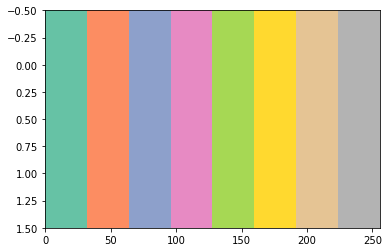

In [3]:
name = 'Set2'
ax = plt.gca()
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))
ax.imshow(gradient, aspect='auto', cmap=plt.get_cmap(name))

In [ ]:
# try organizing vertically
# - all axes need labels
# - play around with order of NMF barplots so that there's more "structure"
# - put top features in the text to justify labelling of factors
# - label x-axis of barplots and y-axis of heatmaps

# swap 1st and second column
# add color bar for heat maps
# add axis labels
# add labels to x-axis of bar plot and to y-axis of heatmap
# order bars by size of max component


# this is really shaping up nicely. looks great. in c& d, can you make the bars:
# -reduce the size of that subplot relative to the NMF weightings (it conveys less information)
# -increase font/sparsify number labels on y-axis
# -bring c&d closer to A&B
# -i thought we decided on a less controversial name for 'PE race-related'.

def add_legend(ax, labels, **kwargs):
    palette = sns.color_palette('Set2', len(labels))
    ax.legend([mpatches.Patch(color=c) for c in palette], labels, **kwargs)


def add_label(ax, label):
    ax.text(-0.1, 1.03, label, transform=ax.transAxes, weight='bold', size='xx-large')    
#################################################
fig_v = 8
fig = plt.figure(figsize=(2*fig_v, 3*fig_v))

v = 8
u = 3
gsMain = mgrid.GridSpec(3*v+u, 2*v) #, hspace=1.0, wspace=1.0)

gsMain.tight_layout(fig)

axA = fig.add_subplot(gsMain[0:v, :v])

axB = fig.add_subplot(gsMain[0:v, v:])

axE = fig.add_subplot(gsMain[2*v+u:, :v])
axF = fig.add_subplot(gsMain[2*v+u:, v:])




gsC = mgrid.GridSpecFromSubplotSpec(v, v+u, subplot_spec=gsMain[v:2*v+u, :v], hspace=0.02)
gsD = mgrid.GridSpecFromSubplotSpec(v, v+u, subplot_spec=gsMain[v:2*v+u, v:], hspace=0.02)

axC1, axC2 = fig.add_subplot(gsC[0, :]), fig.add_subplot(gsC[1:, :])

axD1, axD2 = fig.add_subplot(gsD[0, :]), fig.add_subplot(gsD[1:, :])

#fig, axes = plt.subplots(3, 2, figsize=(15, 20))

bm_colors = sns.color_palette('Set2', 8)
# bm_colors = [bm_colors[i] for i in (7,1,2,3,4)] # gray instead of turqoise
bm_colors = [bm_colors[i] for i in (5,1,2,3,4)]  # yellow instead of turqoise
nmfplot(bm_weights, bm_bases, axes=[axA, axC1, axC2], bases_order=False, bases_labels=bm_bases_labels, 
        fontsize='x-large', heatmap_xlabel='Biomarkers', palette=bm_colors)
# pie_chart_scatter(bm_weights/np.sum(bm_bases != 0, axis=1), bm_emb, s=70, ax=axE, fontsize='x-large', palette=bm_colors)
plot_umap_nmf_colors(tbifile.biomarkers, bm_weights, bm_bases_labels, min_dist=1.0, ax=axE, legend=False)

nmfplot(oc_weights, oc_bases, axes=[axB, axD1, axD2], bases_order=False, bases_labels=oc_bases_labels, fontsize='x-large', heatmap_xlabel='Outcomes')
# pie_chart_scatter(oc_weights/np.sum(oc_bases != 0, axis=1), oc_emb, s=70, ax=axF, fontsize='x-large')
plot_umap_nmf_colors(tbifile.outcomes, oc_weights, oc_bases_labels, right=True, ax=axF, legend=False)


for ax, lbl in zip([axA, axB, axC1, axD1, axE, axF] , "ABCDEF"):
    add_label(ax, lbl)
    
#gsMain.update(hspace=275.0, wspace=1005.0)

    
# for ax in axes.ravel():
#     ax.set_xticks([])
#     ax.set_yticks([])

    
#add_legend(axes[0,0], bm_bases_labels, fontsize='large', loc='upper right', bbox_to_anchor=(0, 1.0))
#add_legend(axes[1,0], oc_bases_labels, fontsize='large', loc='upper right', bbox_to_anchor=(0, 1.0))

# plt.tight_layout(h_pad=0.02)
plt.tight_layout()
plt.savefig('../../paper/MultiPanel_latent_features.png', dpi=200)